In [1]:
import numpy as np
import os, json, cv2, random

In [2]:
import json
  
# Opening JSON file
f = open('/root/labelstudio/result.json')
  
dataset_dicts = json.load(f)

dataset_dicts.keys()

dataset_dicts['categories']

[{'id': 0, 'name': 'Bundle'}]

In [3]:
dataset_dicts['images']

[{'width': 3024,
  'height': 4032,
  'id': 0,
  'file_name': '82e70341-IMG_0331.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 1,
  'file_name': 'f7cae16f-IMG_0330.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 2,
  'file_name': '90798fb9-IMG_0329.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 3,
  'file_name': 'ea30c502-IMG_0326.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 4,
  'file_name': '677d6212-IMG_0323.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 5,
  'file_name': '991068d7-IMG_0322.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 6,
  'file_name': '84699595-IMG_0321.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 7,
  'file_name': '1ea3cfcf-IMG_0320.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 8,
  'file_name': '59b6b761-IMG_0319.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 9,
  'file_name': 'efb3e0be-IMG_0318.JPG'},
 {'width': 3024,
  'height': 4032,
  'id': 10,
  'file_name': 'c17bf3e5-IMG_0316.JPG'},
 {'width': 3024,
  'height': 4032,
  'id':

In [4]:
import matplotlib.pyplot as plt

from skimage.io import imshow, imread
from skimage.color import rgb2hsv, hsv2rgb

/root/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
im = imread("/root/labelstudio/images/"+dataset_dicts['images'][10]['file_name'])

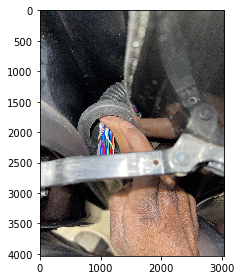

In [7]:
imshow(im)

In [8]:
im1 = im[ 1849: 2392, 894:1232]

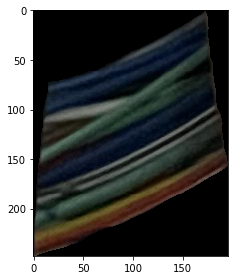

In [46]:
imshow(im1)

In [51]:
def light_level(img,thres = 60):
    r,g,b,_ = cv2.mean(im1)
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    if gray <= 60:
        return "dark"
    else :
        return "okay light"

In [52]:
def change_brightness(img, value=60):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [53]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [54]:
def is_blurry(image, threshold = 80):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)
    text = "Not Blurry"
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < threshold:
        text = "Blurry"
    return [text, round(fm,2)]

In [62]:
from sklearn.linear_model import LinearRegression
def count_yellow_wires(im1,blur):
    
    original = im1.copy()
    image = cv2.cvtColor(im1, cv2.COLOR_BGR2HSV)
    lower = np.array([90, 90, 0], dtype="uint8")
    upper = np.array([255, 255, 80], dtype="uint8")
    mask = cv2.inRange(im1, lower, upper)

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
       
    def fit_line(c):
    
        model = LinearRegression()
        model.fit(c[:,:,0],[a[0] for a  in c[:,:,1]])
        return (model.coef_[0],model.intercept_,(c[:,:,0].mean(),c[:,:,1].mean()))
    
    def get_dist(line1, line2):
        m_avg = (line1[0]+line2[0])/2
        y2 = line2[2][1]
        y1 = line1[2][1]
        x2 = line2[2][0]
        x1 = line1[2][0]

        c2 = y2 - m_avg*x2
        c1 = y1 - m_avg*x1

        return (abs(c2 - c1)/np.sqrt(1 + m_avg**2))
    
    def is_same_line(line1, line2,ang_thres = 6, dist_thres = 10):
    
        if abs(np.rad2deg(line1[0]) - np.rad2deg(line2[0])) < ang_thres:
            if get_dist(line1, line2) < dist_thres:
                return True
        return False
    
    canvas = np.zeros(image.shape,np.uint8)
    canvas.fill(255)
    num_cnts =0
    ctr_lines = []
    for a,c in enumerate(cnts):
        if cv2.contourArea(c)>20:
            num_cnts +=1
            #print(f"num_cnts = {num_cnts}")
            cv2.drawContours(canvas, cnts, a,(0,255,0),2)
            ctr_lines.append(fit_line(c))
            

    def count_wires(ctr_lines,ang_thres = 6, dist_thres = 10):
        grp_dict = {} 
        for i in ctr_lines:

            for j in grp_dict.keys():
                if is_same_line(i,j,ang_thres, dist_thres):
                    #grp_dict[j] = 
                    grp_dict[j].append(i)
                    #print(f"found {i}:{j}")
                    #print(grp_dict)
                    break


            else :
                grp_dict[i] = [i]
        #print(grp_dict)
        return len(grp_dict)

    no_wires = count_wires(ctr_lines,15,25)
    
    fig, ax = plt.subplots(1,3, figsize = (12,5))

    ax[0].imshow(im1)
    ax[1].imshow(mask)
    ax[2].imshow(canvas)

    ax[0].set_title(f"original image {blur}")
    ax[1].set_title(f"Mask Image - contours : {num_cnts}")
    ax[2].set_title(f"original image wires - {no_wires}")
    
    
    fig.show()
    
    return no_wires

In [63]:
bbox = {}
for i in dataset_dicts['annotations']:
    bbox[i['id']]= i['bbox']

In [64]:
name = {}
for i in dataset_dicts['images']:
    name[i['id']]= i['file_name']

In [65]:
im1 = imread("/root/labelstudio/images/"+ dataset_dicts['images'][0]['file_name'])

In [66]:
from pycocotools.coco import COCO

In [67]:
coco = COCO('/root/labelstudio/result.json')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/tmp/ipykernel_2175/2334684345.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3, figsize = (12,5))


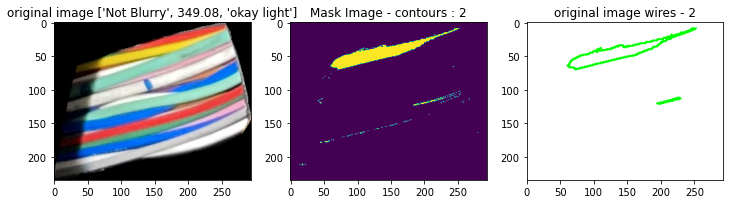

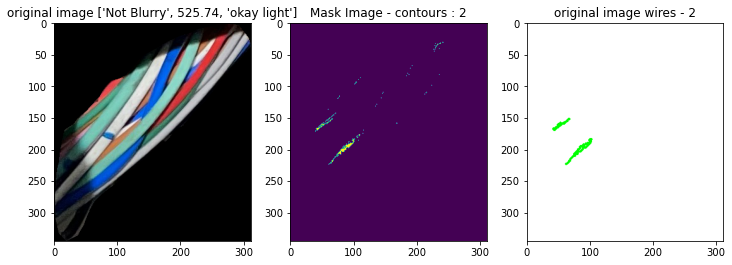

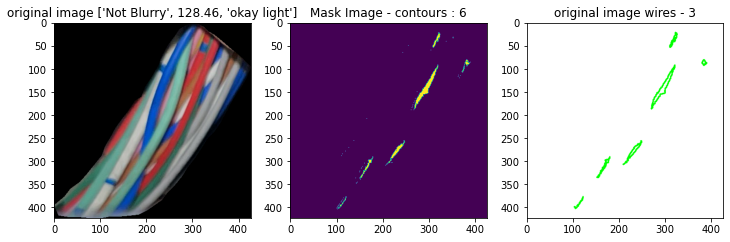

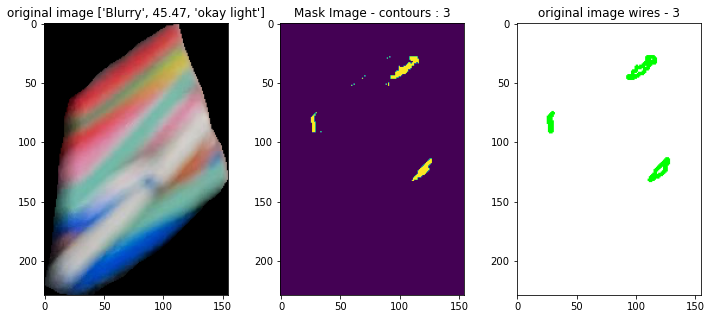

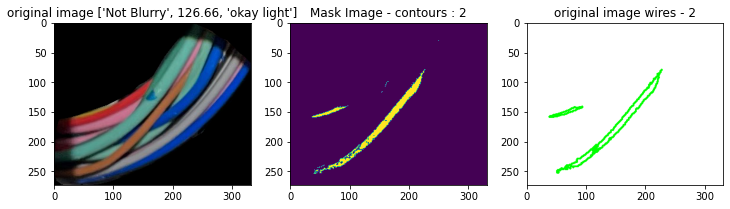

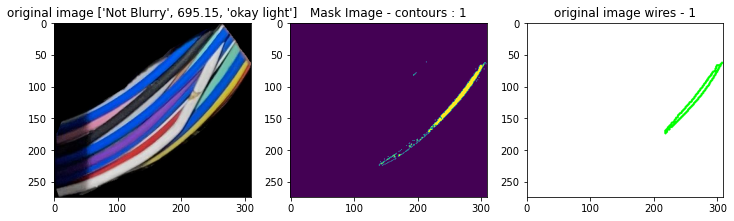

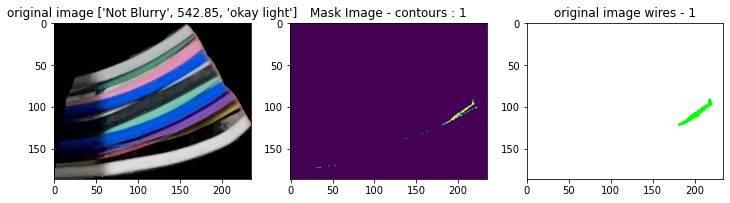

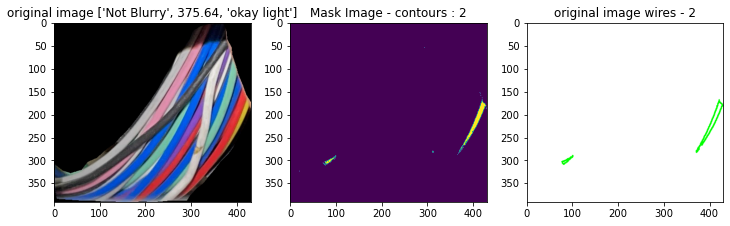

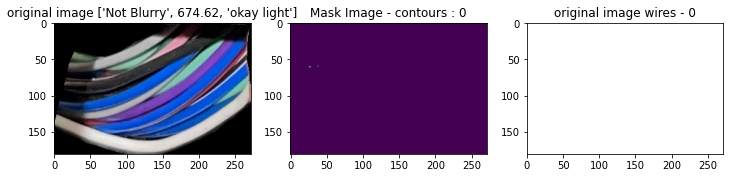

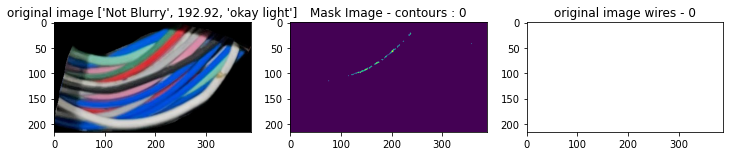

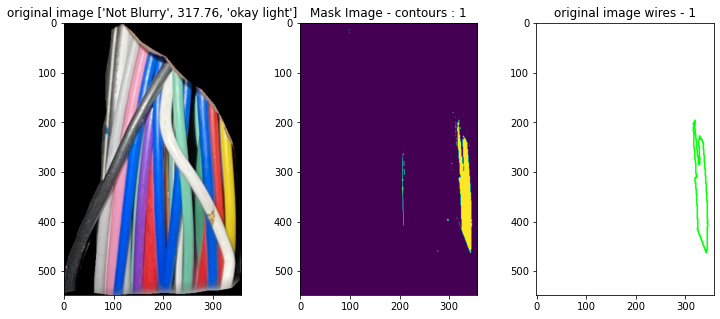

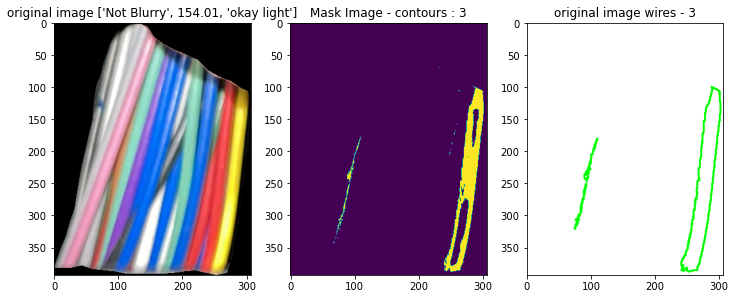

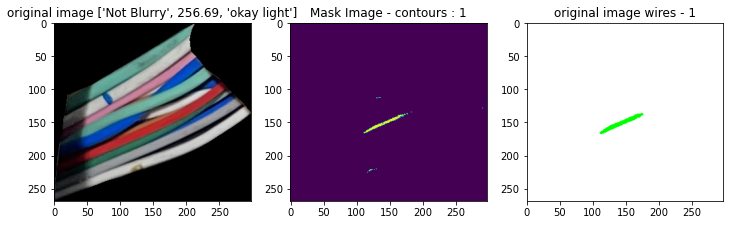

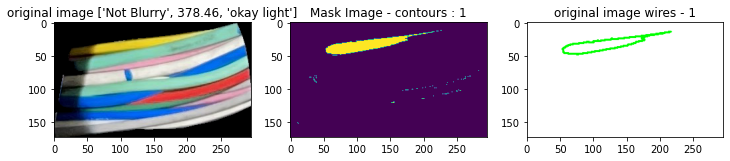

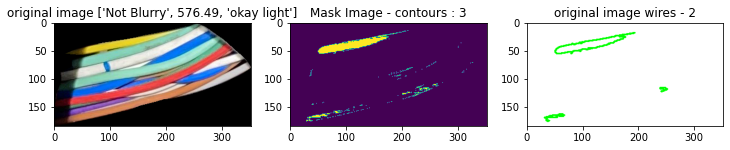

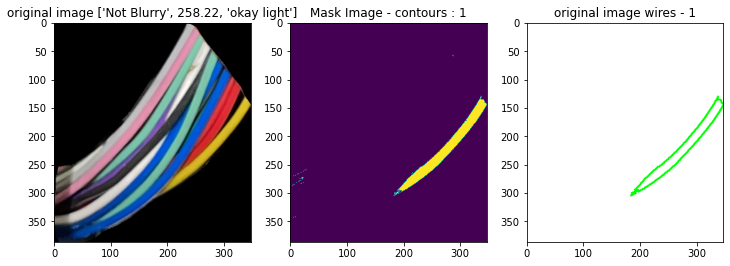

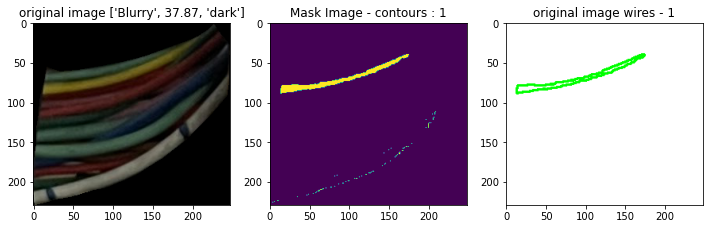

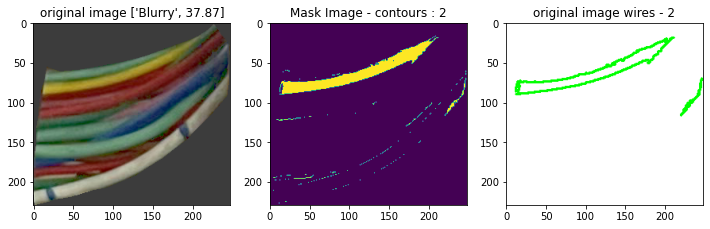

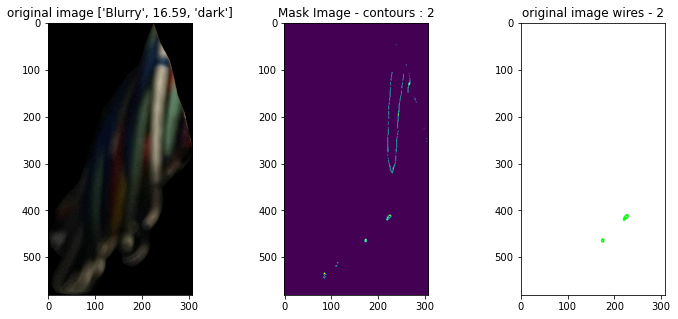

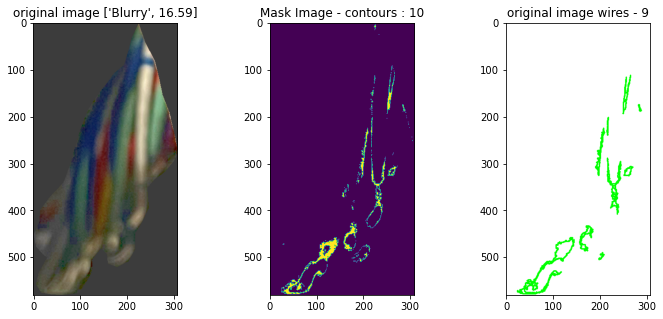

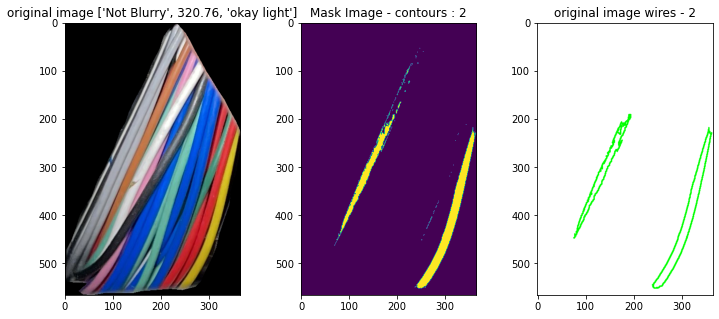

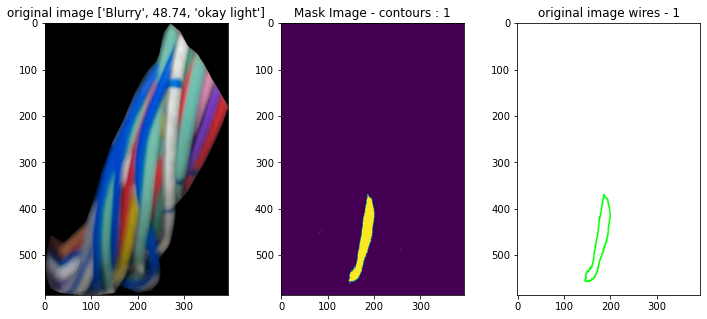

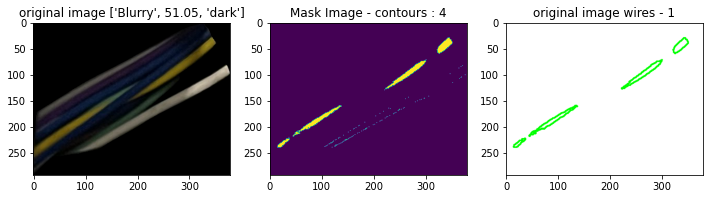

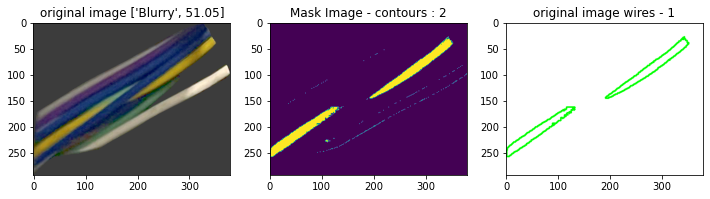

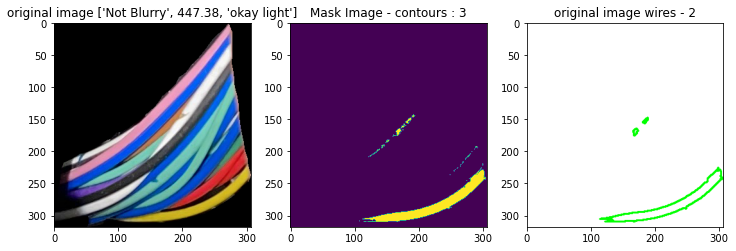

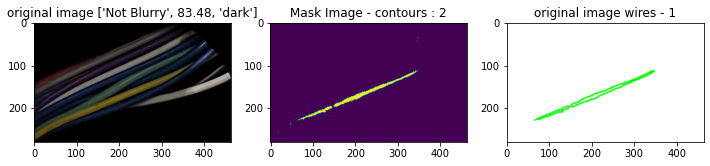

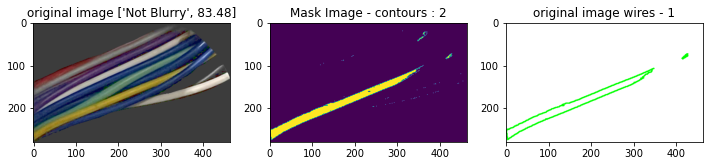

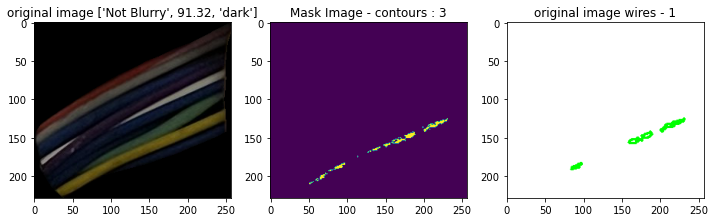

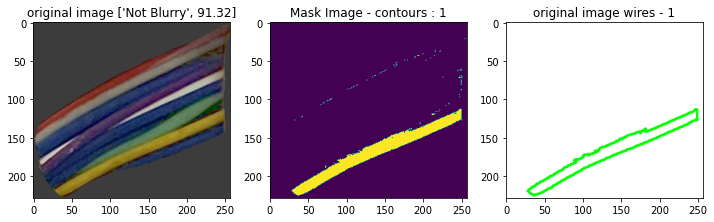

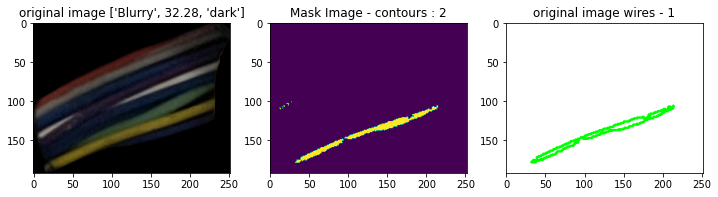

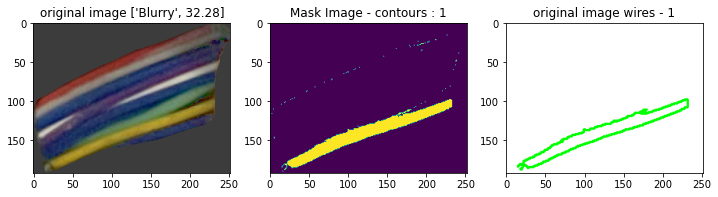

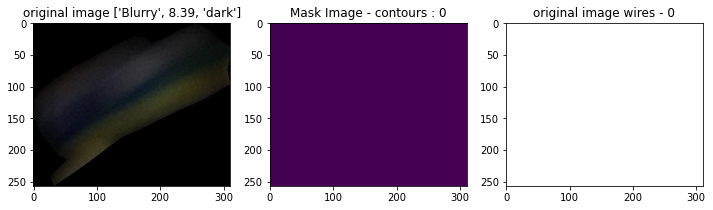

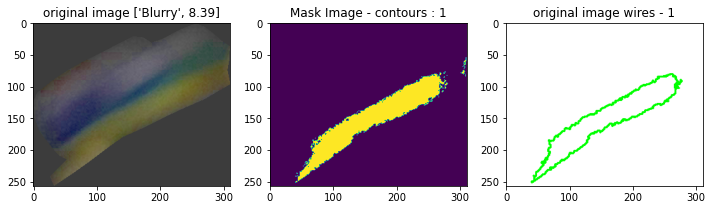

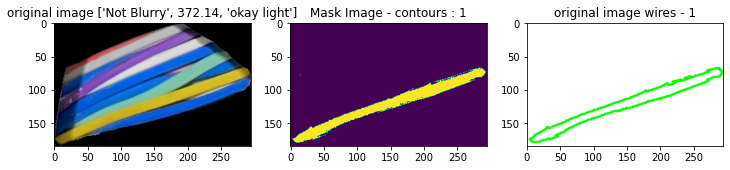

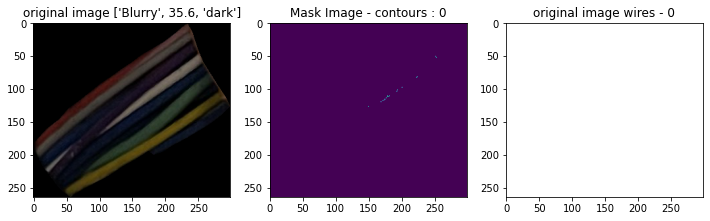

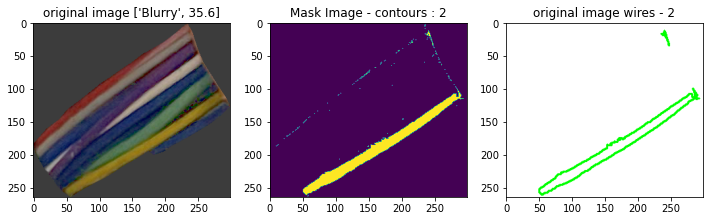

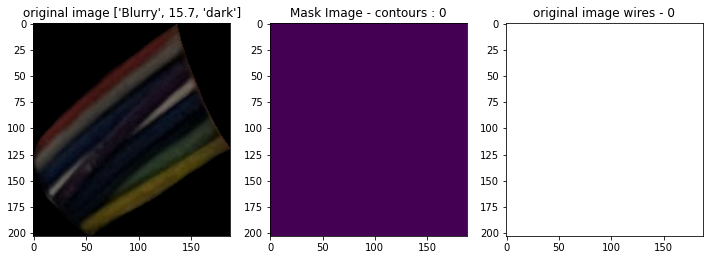

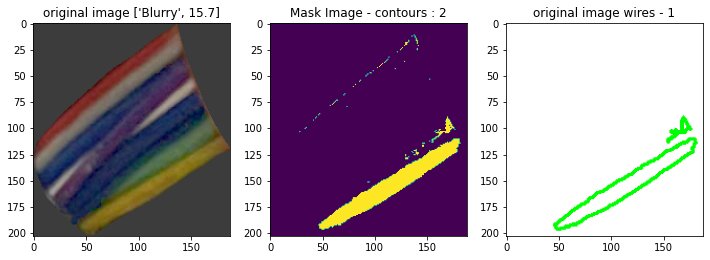

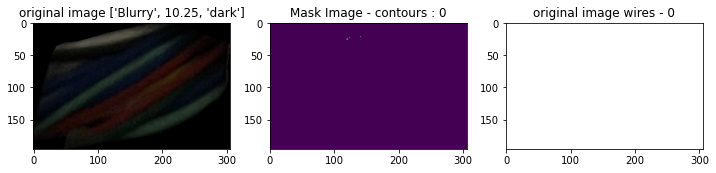

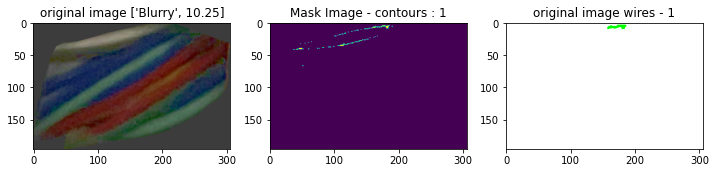

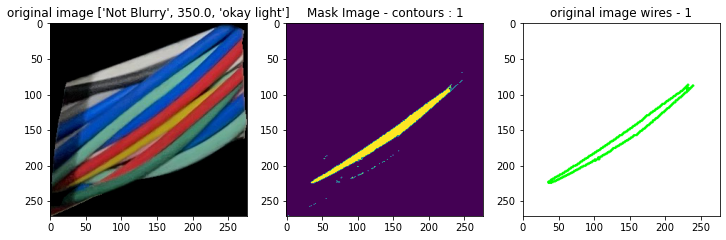

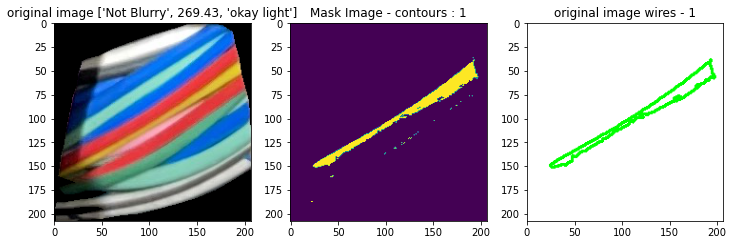

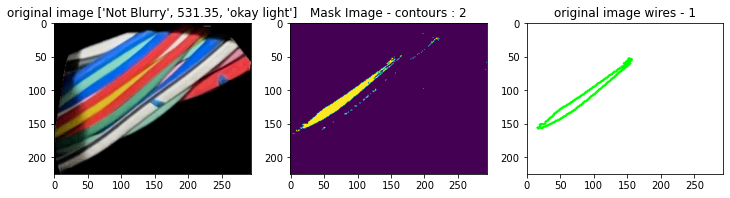

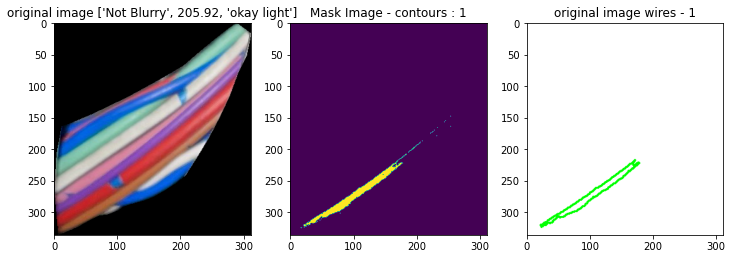

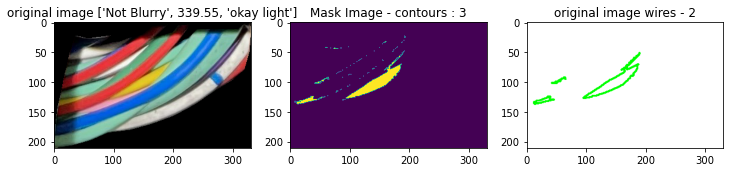

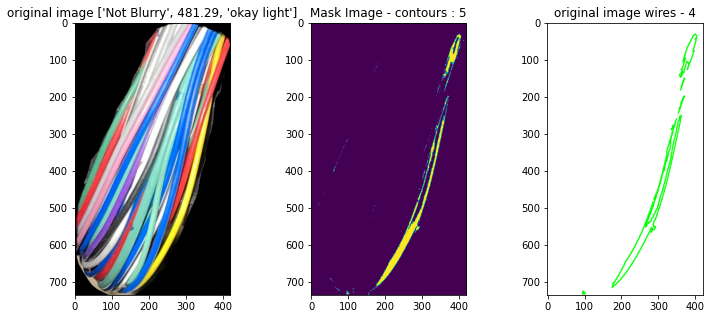

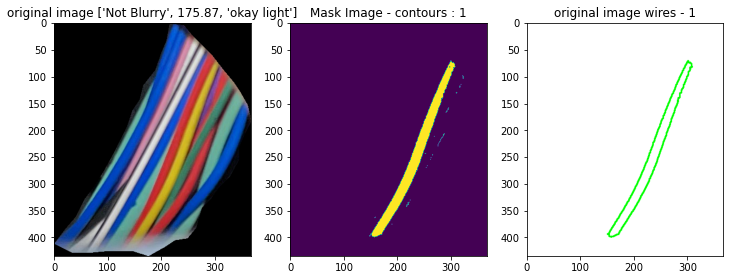

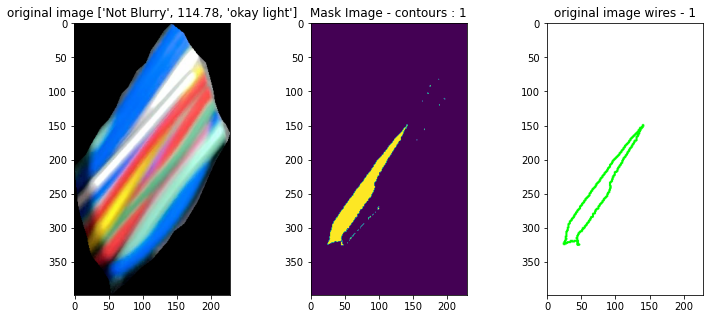

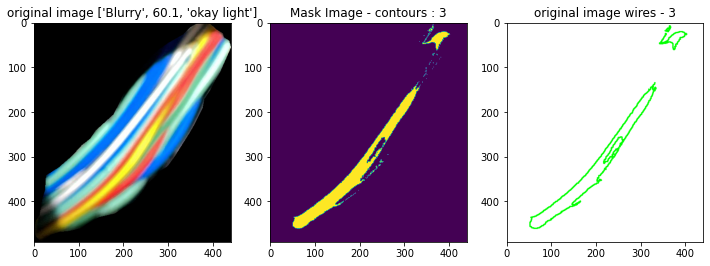

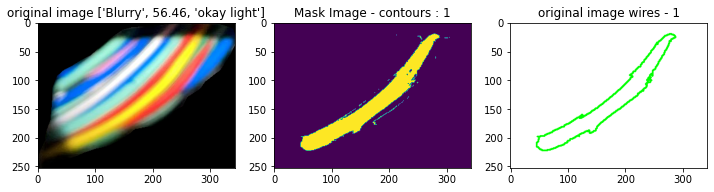

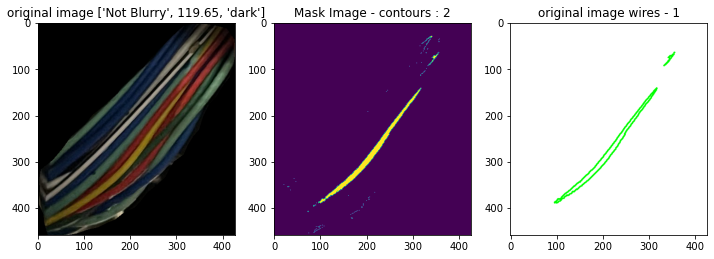

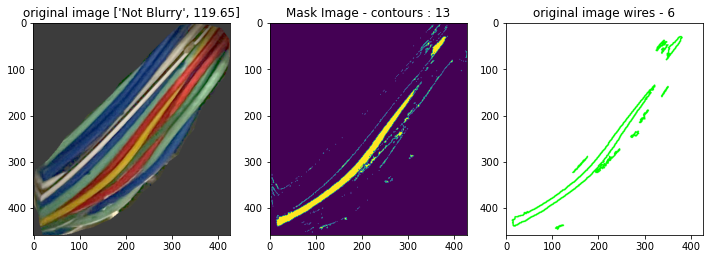

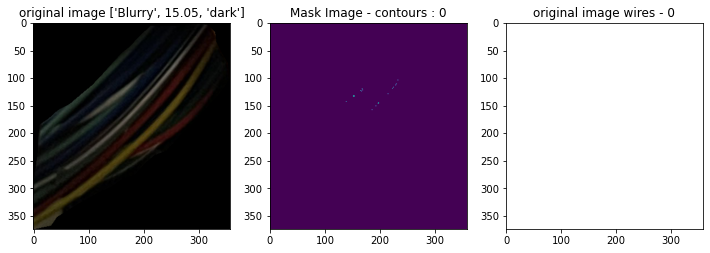

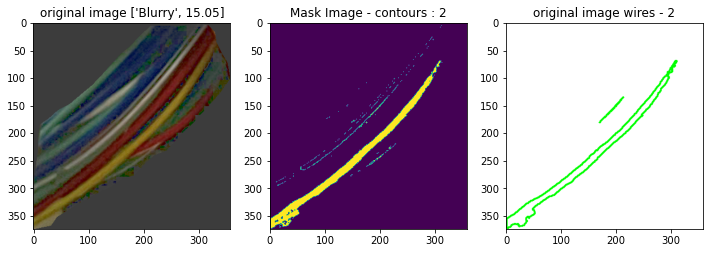

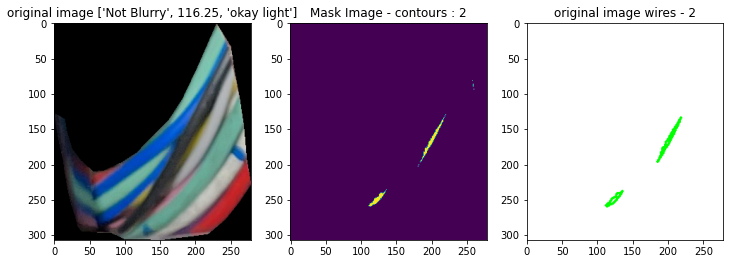

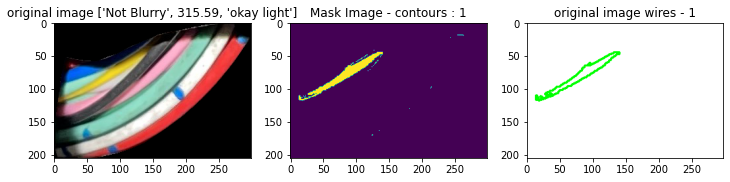

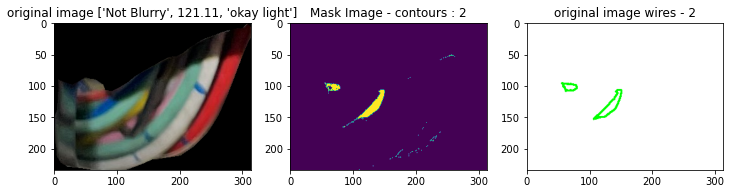

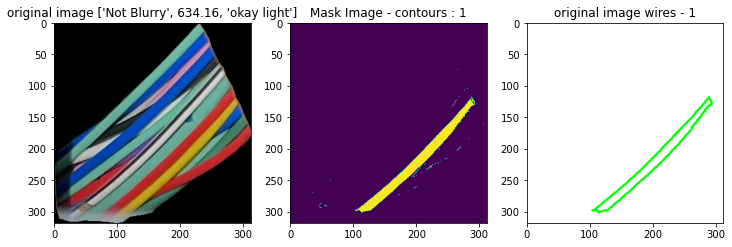

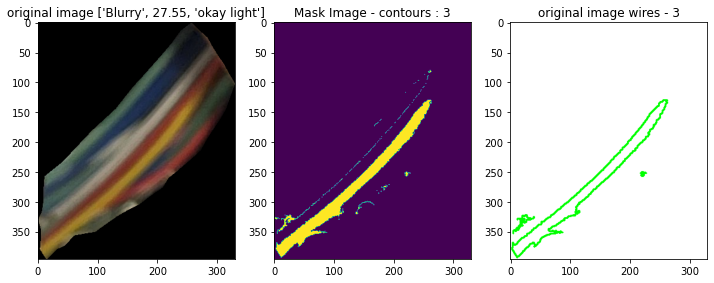

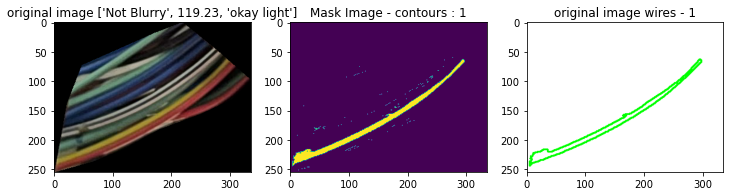

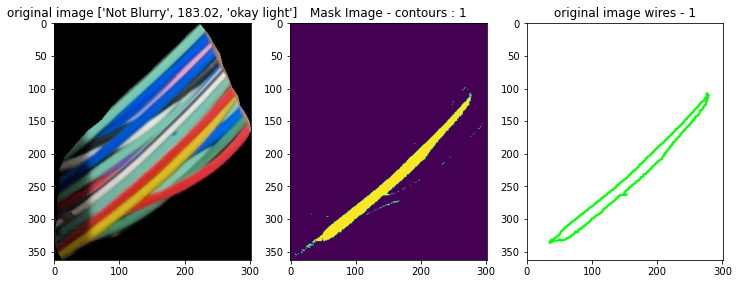

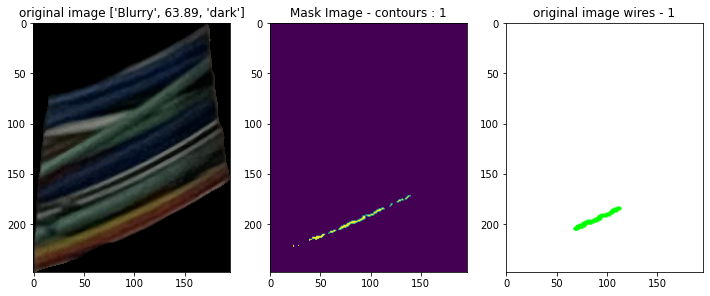

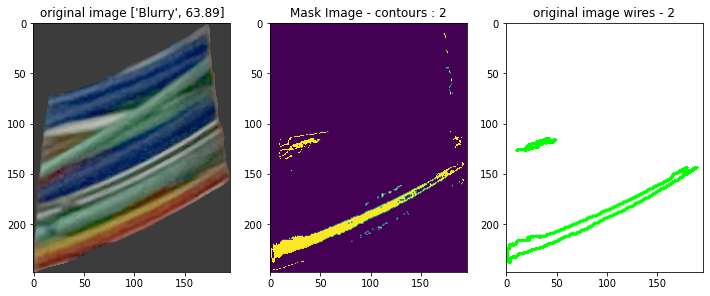

In [68]:
for i,j in list(name.items()):
    im1 = imread("/root/labelstudio/images/"+j)
    #bbox_pts = bbox[i]
    x1, y1, w, h  = bbox[i]
    x2 = x1 + w
    y2 = y1 + h
    mask = coco.annToMask(dataset_dicts['annotations'][i])
    # for i in range(len(anns)):
    #      mask += coco.annToMask(anns[i])
    
    light_lvl = light_level(im1[int(y1):int(y2),int(x1):int(x2)])
    blur = is_blurry(im1[int(y1):int(y2),int(x1):int(x2)]) + [light_lvl]
    
    im1[:,:,0]=im1[:,:,0]*mask
    im1[:,:,1]=im1[:,:,1]*mask
    im1[:,:,2]=im1[:,:,2]*mask

    im1 = im1[int(y1):int(y2),int(x1):int(x2)]
    count_yellow_wires(im1,blur)
    if light_lvl == "dark":
        count_yellow_wires(change_brightness(im1),blur[:2])

In [ ]:
import numpy as np
import cv2

original = im1.copy()
image = cv2.cvtColor(im1, cv2.COLOR_BGR2HSV)
lower = np.array([90, 90, 0], dtype="uint8")
upper = np.array([255, 255, 80], dtype="uint8")
mask = cv2.inRange(im1, lower, upper)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

In [ ]:
canvas = np.zeros(image.shape,np.uint8)
canvas.fill(255)

In [ ]:
imshow(mask)

NameError: name 'no_wires' is not defined

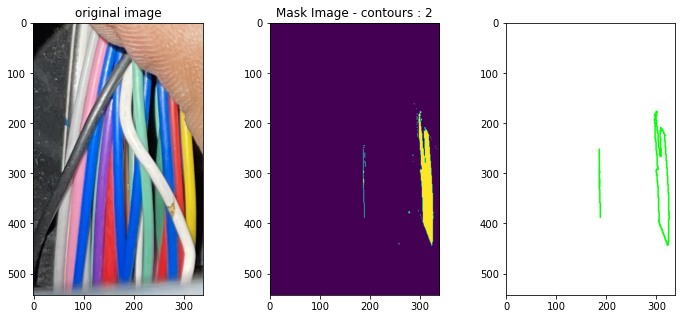

In [28]:
fig, ax = plt.subplots(1,3, figsize = (12,5))

ax[0].imshow(im1)
ax[1].imshow(mask)
ax[2].imshow(canvas)

ax[0].set_title("original image")
ax[1].set_title(f"Mask Image - contours : {num_cnts}")
ax[2].set_title(f"original image wires - {no_wires}")

In [24]:
# mask = np.zeros(image.shape,np.uint8)
# mask.fill(255)

In [25]:
num_cnts =0 
for a,c in enumerate(cnts):
    if cv2.contourArea(c)>10:
        num_cnts +=1
        print(f"num_cnts = {num_cnts}")
        cv2.drawContours(canvas, cnts, a,(0,255,0),2)

num_cnts = 1
num_cnts = 2


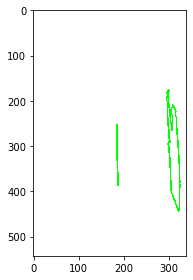

In [26]:
imshow(canvas)

In [15]:
im = imread("/root/labelstudio/images/"+dataset_dicts['images'][20]['file_name'])

In [16]:
im1=im[2080:2300,800:1300]

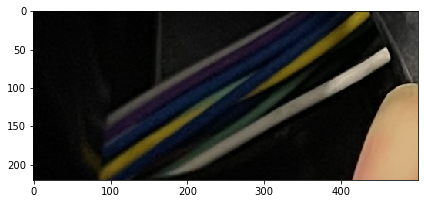

In [17]:
imshow(im1)

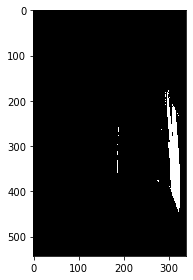

In [18]:
imshow(mask)

In [19]:
num_cnts =0 
for a,c in enumerate(cnts):
    if cv2.contourArea(c)>10:
        num_cnts +=1
        print(f"num_cnts = {num_cnts}")
        cv2.drawContours(canvas, cnts, a,(0,255,0),2)

num_cnts = 1
num_cnts = 2


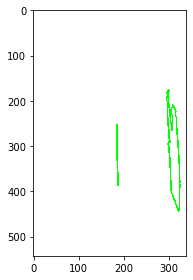

In [20]:
imshow(canvas)

In [21]:
cnts

(array([[[256, 439]],
 
        [[256, 441]]], dtype=int32),
 array([[[302, 392]]], dtype=int32),
 array([[[301, 389]]], dtype=int32),
 array([[[300, 387]]], dtype=int32),
 array([[[299, 384]]], dtype=int32),
 array([[[298, 382]]], dtype=int32),
 array([[[275, 376]],
 
        [[275, 377]],
 
        [[276, 378]],
 
        [[276, 379]],
 
        [[277, 379]],
 
        [[277, 376]]], dtype=int32),
 array([[[295, 375]]], dtype=int32),
 array([[[294, 373]]], dtype=int32),
 array([[[284, 276]]], dtype=int32),
 array([[[188, 275]],
 
        [[188, 278]],
 
        [[189, 279]],
 
        [[189, 286]],
 
        [[189, 278]],
 
        [[188, 277]]], dtype=int32),
 array([[[283, 263]],
 
        [[284, 264]],
 
        [[284, 263]]], dtype=int32),
 array([[[188, 259]],
 
        [[188, 268]]], dtype=int32),
 array([[[185, 251]],
 
        [[185, 318]],
 
        [[186, 319]],
 
        [[185, 320]],
 
        [[185, 331]],
 
        [[186, 332]],
 
        [[186, 358]],
 
        [[187, 

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
def fit_line(c):
    
    model = LinearRegression()

    model.fit(c[:,:,0],[a[0] for a  in c[:,:,1]])

    return (model.coef_[0],model.intercept_,(c[:,:,0].mean(),c[:,:,1].mean()))


In [30]:
def get_dist(line1, line2):
    m_avg = (line1[0]+line2[0])/2
    y2 = line2[2][1]
    y1 = line1[2][1]
    x2 = line2[2][0]
    x1 = line1[2][0]
    
    c2 = y2 - m_avg*x2
    c1 = y1 - m_avg*x1
    
    return (abs(c2 - c1)/np.sqrt(1 + m_avg**2))

In [31]:
def is_same_line(line1, line2,ang_thres = 6, dist_thres = 10):
    
    if abs(np.rad2deg(line1[0]) - np.rad2deg(line2[0])) < ang_thres:
        if get_dist(line1, line2) < dist_thres:
            return True
    return False

In [32]:
num_cnts =0
ctr_lines = []
for a,c in enumerate(cnts):
    if cv2.contourArea(c)>10:
        num_cnts +=1
        print(f"num_cnts = {num_cnts}")
        cv2.drawContours(canvas, cnts, a,(0,255,0),2)
        ctr_lines.append(fit_line(c))

num_cnts = 1
num_cnts = 2


In [33]:
ctr_lines

[(22.974110032362468,
  -3941.1165048543708,
  (185.65384615384616, 324.11538461538464)),
 (5.980183596413931,
  -1544.8374933546834,
  (307.9940828402367, 297.02366863905326))]

In [41]:
def count_wires(ctr_lines,ang_thres = 6, dist_thres = 10):
    grp_dict = {} 
    for i in ctr_lines:
    
        for j in grp_dict.keys():
            if is_same_line(i,j,ang_thres, dist_thres):
                #grp_dict[j] = 
                grp_dict[j].append(i)
                #print(f"found {i}:{j}")
                #print(grp_dict)
                break

        
        else :
            grp_dict[i] = [i]
    print(grp_dict)
    return len(grp_dict)

In [42]:
count_wires(ctr_lines,6,5)

{(22.974110032362468, -3941.1165048543708, (185.65384615384616, 324.11538461538464)): [(22.974110032362468, -3941.1165048543708, (185.65384615384616, 324.11538461538464))], (5.980183596413931, -1544.8374933546834, (307.9940828402367, 297.02366863905326)): [(5.980183596413931, -1544.8374933546834, (307.9940828402367, 297.02366863905326))]}


2

In [36]:
count_wires(ctr_lines,6,10)

2

In [37]:
count_wires(ctr_lines,6,20)

2

In [38]:
count_wires(ctr_lines,6,25)

2

In [62]:
ctr_lines

[(-0.6260597124953924,
  266.5189826760044,
  (110.84848484848484, 197.12121212121212)),
 (-0.6152596104850021,
  262.2384246573066,
  (174.7876712328767, 154.6986301369863)),
 (-0.7038690386648135,
  310.313057974154,
  (347.42622950819674, 65.77049180327869)),
 (-0.6012256511271615,
  266.37032173342095,
  (420.8181818181818, 13.363636363636363))]

In [65]:
ctr_lines=ctr_lines[1:]

In [40]:
dist_dict = {}
for a,i in enumerate(ctr_lines):
    min_dist = np.inf
    for b,j in enumerate(ctr_lines):
        if a == b:
            pass
        
        else:
            print((a,b), get_dist(i,j),min_dist)
            if get_dist(i,j) < min_dist:
                
                dist_dict[a] = b
                min_dist = get_dist(i,j)
                print((a,b), get_dist(i,j),min_dist)
            
    
print(dist_dict)

(0, 1) 123.91631293640566 inf
(0, 1) 123.91631293640566 123.91631293640566
(1, 0) 123.91631293640566 inf
(1, 0) 123.91631293640566 123.91631293640566
{0: 1, 1: 0}


In [67]:
for i in ctr_lines:
    print(get_dist(ctr_lines[1], i))

20.817738058342332
0.0
3.7812760346847547


In [68]:
for i in ctr_lines:
    print(get_dist(ctr_lines[2], i))

7.100887146344556
3.7812760346847547
0.0


In [1]:
for i in ctr_lines:
    print(get_dist(ctr_lines[3], i))

NameError: name 'ctr_lines' is not defined

In [195]:
### Blur
### Small seactions
### light
### orange
### erosion and dialation method